In [7]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from datetime import datetime

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!pip install pydot
!rm -rf ./logs/ 

/Users/samholt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Regression with Keras

So far we have mainly looked at the digits dataset, which is a classification problem with *Keras*, however it is also easy to create a regression model, we simply change the output to a single `tf.keras.layers.Dense` layer with one unit and no activation function. This outputs a scalar value that is unbounded, and is the sum of the weighted inputs from the previous layer.

I.e. a model of the form

In [247]:
from tensorflow import keras


def new_model():
    units = 32
    model = keras.Sequential([
        keras.layers.Dense(units, activation='relu', input_shape=[13]),
        keras.layers.Dense(units, activation='relu'),
        keras.layers.Dense(1)
    ])

    # Compile the regression model
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model


model = new_model()

We can train such a model on a the boston housing dataset, i.e. the 

In [248]:
(X_train, y_train), (X_test, y_test) = keras.datasets.boston_housing.load_data()

In [249]:
epochs = 1201

# Train the regression model
history = model.fit(X_train, y_train, epochs=epochs,
                    verbose=0, validation_split=0.2)

We can visualise the models training metrics over each epoch by the attributes of the `history` object

In [250]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,9894.977196,96.888802,9894.977539,7719.285651,85.708160,7719.285645,0
1,7032.431863,81.358284,7032.432617,5575.864523,72.507393,5575.864746,1
2,5109.908837,68.937836,5109.908691,3960.269685,60.700851,3960.269775,2
3,3608.224305,57.477833,3608.224121,2725.106783,49.825184,2725.106934,3
4,2455.204007,46.685665,2455.204102,1758.769882,39.302483,1758.769897,4
...,...,...,...,...,...,...,...
1196,24.721123,3.571968,24.721123,37.126829,4.165478,37.126831,1196
1197,25.162322,3.526802,25.162323,34.813485,4.095631,34.813488,1197
1198,24.590155,3.516155,24.590155,38.949530,4.990527,38.949528,1198
1199,25.960507,3.666762,25.960505,39.367572,5.062441,39.367573,1199


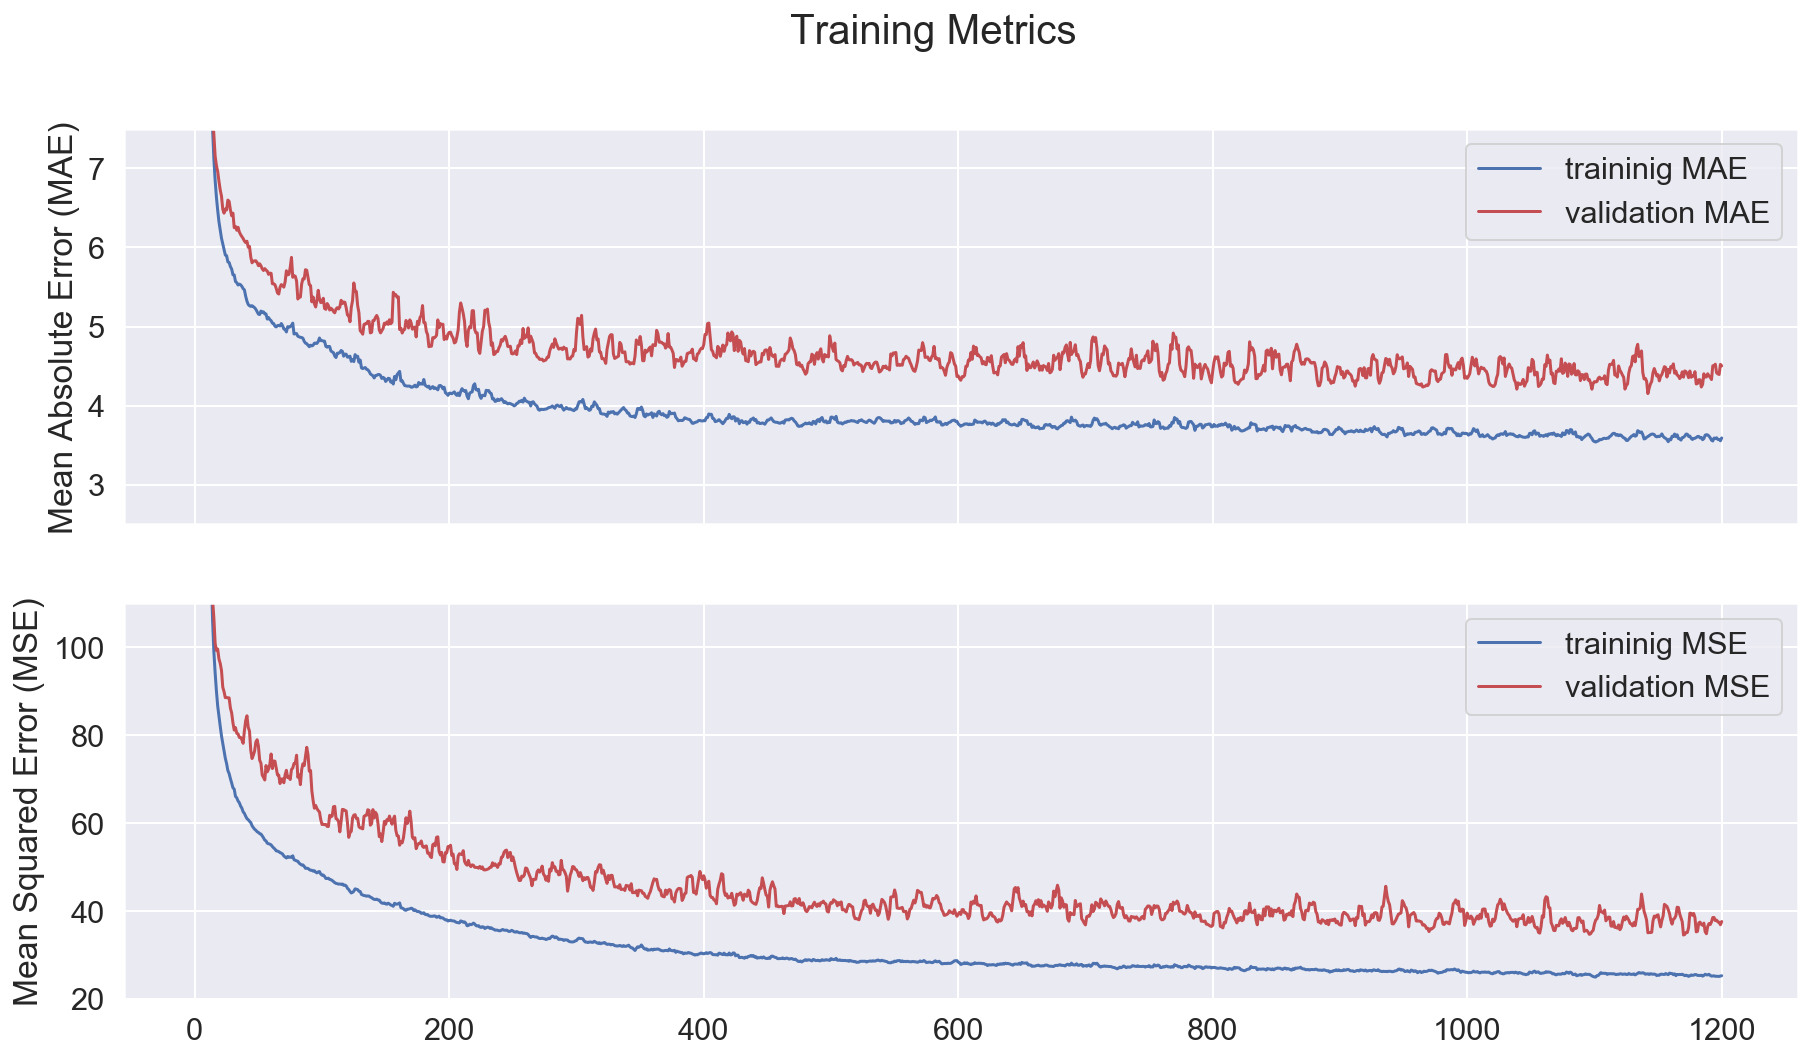

In [251]:
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 5

axes[0].set_ylabel("Mean Absolute Error (MAE)")
axes[0].plot(history_df['mae'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_mae'].rolling(epochs_to_mean).mean(), '-r')
axes[0].set_ylim(2.5, 7.5)
axes[0].legend(['traininig MAE', 'validation MAE'])

axes[1].set_ylabel("Mean Squared Error (MSE)")
axes[1].plot(history_df['mse'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_mse'].rolling(epochs_to_mean).mean(), '-r')
axes[1].set_ylim(20, 110)
axes[1].legend(['traininig MSE', 'validation MSE'])
plt.show()

The plot above shows that that the losses plateau quickly, and that after about 400 epochs the validation mean squared error loss is not reducing. To optomise training, we can use the *EarlyStopping* callback, and set it so that if there is no reductio in the validation MSE after a set amount of epochs we can automatically stop training.

In [252]:
model = new_model()

# Here the patience parameter is the amount of epochs to check for reduction in the validation error
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(X_train, y_train,
                          epochs=epochs, validation_split=0.2, verbose=0,
                          callbacks=[early_stop])

In [253]:
history_df = pd.DataFrame(early_history.history)
history_df['epoch'] = early_history.epoch
history_df

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,573.062976,14.730916,573.062988,291.338277,11.790520,291.338287,0
1,374.244546,12.512031,374.244537,240.854932,10.745763,240.854935,1
2,306.087149,11.495060,306.087158,201.405232,9.935363,201.405228,2
3,252.915200,10.888913,252.915207,174.415891,9.143038,174.415894,3
4,212.075413,10.024055,212.075409,148.792738,9.468246,148.792740,4
...,...,...,...,...,...,...,...
221,37.365651,4.214905,37.365654,54.375081,4.780849,54.375080,221
222,37.197419,4.186444,37.197418,55.187144,4.821309,55.187145,222
223,37.804980,4.247856,37.804977,52.467780,4.819901,52.467781,223
224,37.759149,4.247036,37.759148,59.378870,4.909963,59.378872,224


We can see that it stopped at about epoch before our defined number of epochs, saving computation and resources, plotting the losses from the training below

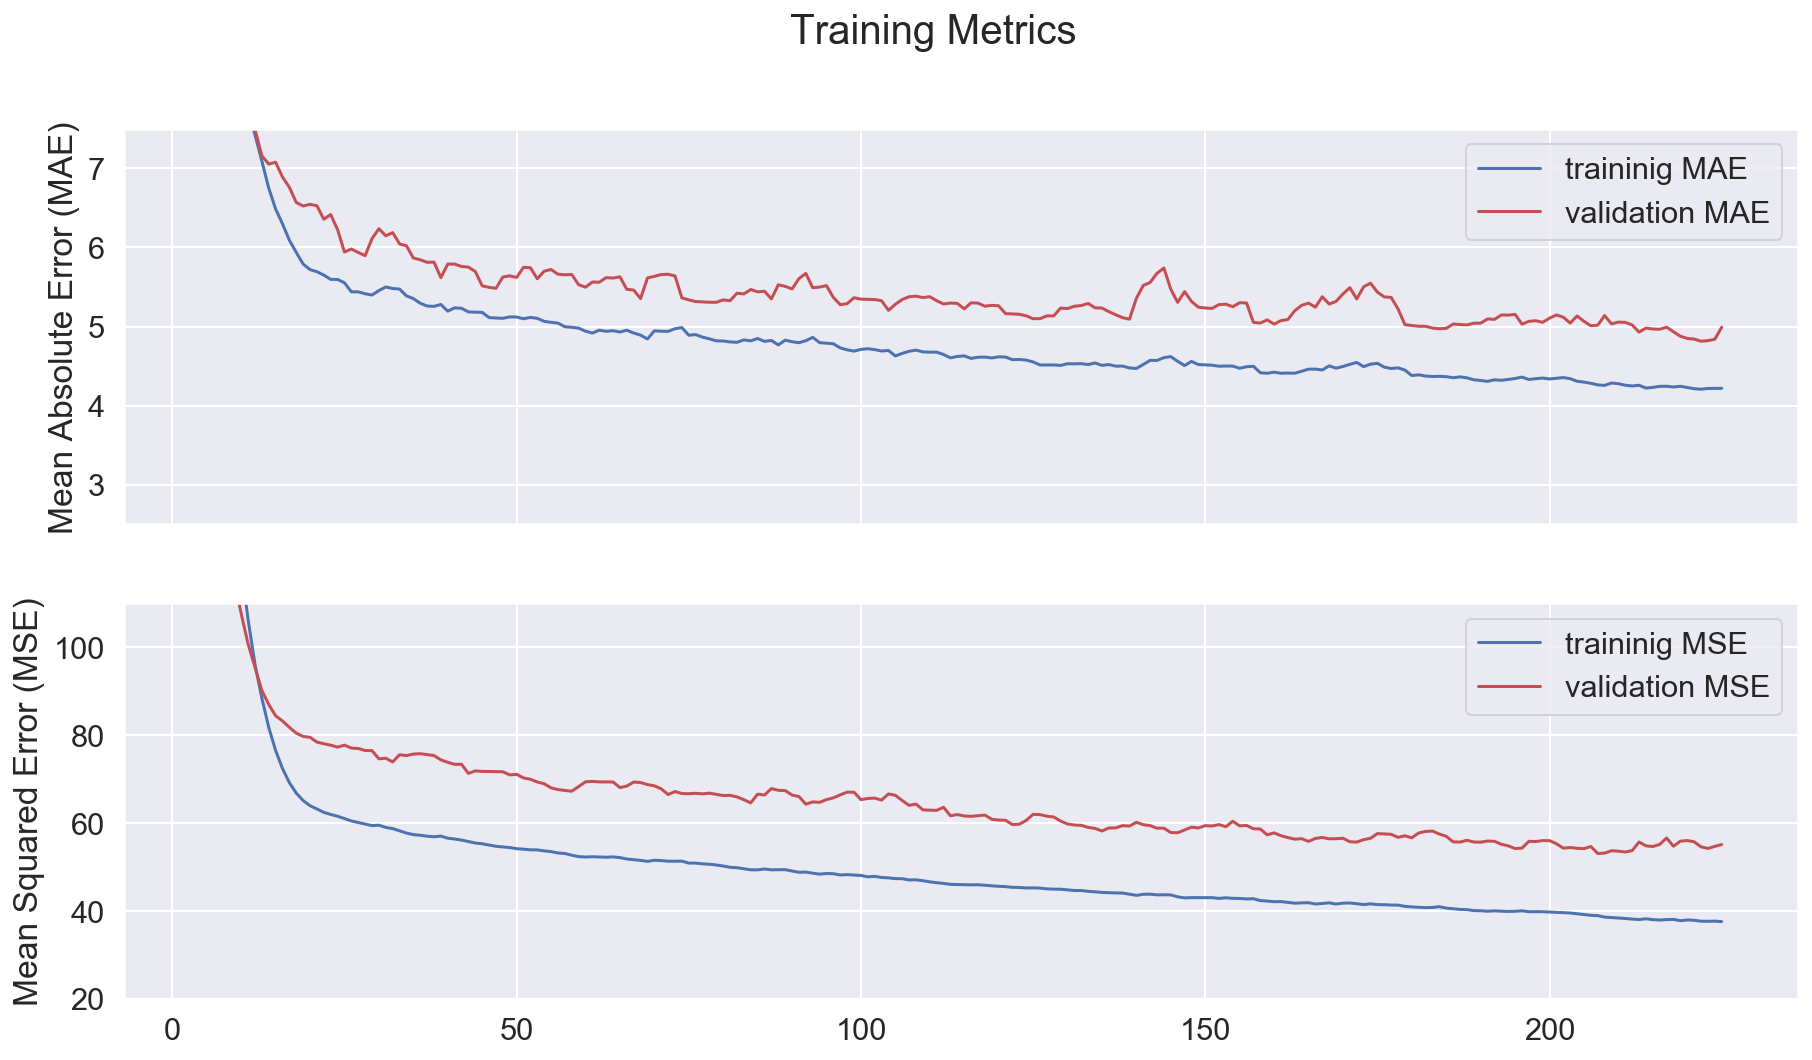

In [254]:
fig, axes = plt.subplots(2, sharex=True, figsize=(15, 8))
fig.suptitle('Training Metrics')

epochs_to_mean = 5

axes[0].set_ylabel("Mean Absolute Error (MAE)")
axes[0].plot(history_df['mae'].rolling(epochs_to_mean).mean(), 'b')
axes[0].plot(history_df['val_mae'].rolling(epochs_to_mean).mean(), '-r')
axes[0].set_ylim(2.5, 7.5)
axes[0].legend(['traininig MAE', 'validation MAE'])

axes[1].set_ylabel("Mean Squared Error (MSE)")
axes[1].plot(history_df['mse'].rolling(epochs_to_mean).mean(), 'b')
axes[1].plot(history_df['val_mse'].rolling(epochs_to_mean).mean(), '-r')
axes[1].set_ylim(20, 110)
axes[1].legend(['traininig MSE', 'validation MSE'])
plt.show()

We can evaluate the model on the test set as well

In [257]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)
print("Test Mean Absolute Error: {:5.2f} in $1000's".format(mae))

102/102 - 0s - loss: 51.2845 - mae: 5.6008 - mse: 51.2845
Test Mean Absolute Error:  5.60 in $1000's



## Regularisers really before this ! 

## Optomisers !

## Normalisation techniques

## Maybe fine tuning some of the neural network parameters and discussion about these here


---

# Training deep neurla netowrks ! - Vanishing & Exploding gradients problems



# Artificial neural networks (ANN)

Will have to do a video on Tensorboard at some point

Optomizers

Activation functions

Initilisation schemes etc

Dropout etc ! 